In [5]:
# Base import and functions

import imutils
import cv2
from imutils import contours
import os, os.path

from tqdm import tqdm

import pytesseract             # Python interface to tesseract for OCR

import numpy as np
from PIL import Image

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [13]:
def build_segmentation_row(filesconut, current_file_index, fig, input_src, serial, number, barcode):
    
    a = fig.add_subplot(filescount, 4, 4 * current_file_index + 1)
    imgplot = plt.imshow(cv2.cvtColor(input_src, cv2.COLOR_BGR2RGB))
    a.set_title('Original')

    a = fig.add_subplot(filescount, 4, 4 * current_file_index + 2)
    imgplot = plt.imshow(cv2.cvtColor(serial, cv2.COLOR_GRAY2RGB))
    a.set_title('Serial')

    a = fig.add_subplot(filescount, 4, 4 * current_file_index + 3)
    imgplot = plt.imshow(cv2.cvtColor(number, cv2.COLOR_GRAY2RGB))
    a.set_title('Number')

    a = fig.add_subplot(filescount, 4, 4 * current_file_index + 4)
    imgplot = plt.imshow(cv2.cvtColor(barcode, cv2.COLOR_GRAY2RGB))
    a.set_title('Barcode')
    
def build_contoured_row(filesconut, current_file_index, fig, input_src, serial, number, barcode):
    
    a = fig.add_subplot(filescount, 4, 4 * current_file_index + 1)
    imgplot = plt.imshow(cv2.cvtColor(input_src, cv2.COLOR_BGR2RGB))
    a.set_title('Original')

    a = fig.add_subplot(filescount, 4, 4 * current_file_index + 2)
    imgplot = plt.imshow(cv2.cvtColor(serial, cv2.COLOR_BGR2RGB))
    a.set_title('Serial')

    a = fig.add_subplot(filescount, 4, 4 * current_file_index + 3)
    imgplot = plt.imshow(cv2.cvtColor(number, cv2.COLOR_BGR2RGB))
    a.set_title('Number')

    a = fig.add_subplot(filescount, 4, 4 * current_file_index + 4)
    imgplot = plt.imshow(cv2.cvtColor(barcode, cv2.COLOR_GRAY2RGB))
    a.set_title('Barcode')

CPU times: user 113 ms, sys: 0 ns, total: 113 ms
Wall time: 81.5 ms


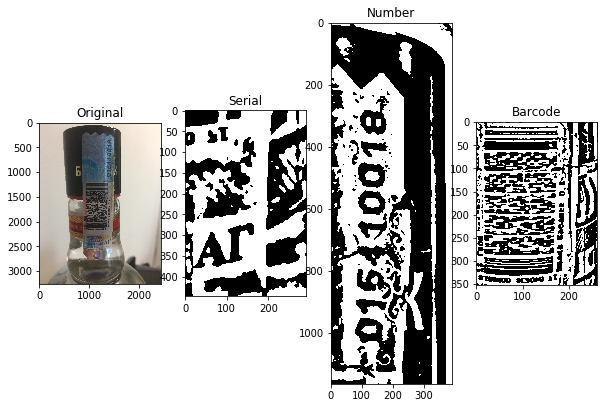

In [14]:
def excise_segmentation(image):
    
    number = image[78:78+1166, 1276:1276+392]
    serial = image[2088:2088+448, 1276:1276+292]
   
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    
    # Serial
    hsv_image = cv2.cvtColor(serial, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv_image)
    v = clahe.apply(v)
    blurred = cv2.bilateralFilter(v, 9, 75, 75)
    blurred = cv2.medianBlur(blurred, 5)
    serial_thresholded = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 255, 1)
    
    edged = cv2.Canny(serial_thresholded, 30, 200)
    refCnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
    serial_contours = np.dstack([serial_thresholded.copy()] * 3)
    for c in refCnts:
        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(serial_contours, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Number
    hsv_image = cv2.cvtColor(number, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv_image)
    v = clahe.apply(v)
    blurred = cv2.bilateralFilter(v, 9, 75, 75)
    blurred = cv2.medianBlur(blurred, 5)
    number_thresholded = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 195, 1)
    
    edged = cv2.Canny(number_thresholded, 30, 200)
    refCnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
    number_contours = np.dstack([number_thresholded.copy()] * 3)
    for c in refCnts:
        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(number_contours, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Barcode
    barcode_thresholded = image[880:880+1408, 828:828+868]
    barcode = imutils.resize(image[880:880+1408, 828:828+868], height=500)
    hsv_image = cv2.cvtColor(barcode, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv_image)
    gray = clahe.apply(v)
    gradX = cv2.Sobel(gray, ddepth = cv2.CV_32F, dx = 1, dy = 0, ksize = -1)
    gradY = cv2.Sobel(gray, ddepth = cv2.CV_32F, dx = 0, dy = 1, ksize = -1)
    gradient = cv2.subtract(gradX, gradY)
    gradient = cv2.convertScaleAbs(gradient)
    blurred = cv2.medianBlur(gradient, 11)
    (_, thresh) = cv2.threshold(blurred, 225, 255, cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    morph = cv2.erode(closed, None, iterations = 11)
    cnts = cv2.findContours(morph.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
    if len(cnts):
        c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
        (x, y, w, h) = cv2.boundingRect(c)
        # PDF417 correction
        x = x - 10 if (x > 10) else 0
        w = w + 20 if (w < 868 - x - 20) else 868 - x
        # Top and bottom black line in PDF417
        y = y - (int)(0.3 * h) if (y > 0.3 * h) else 0
        h = h + (int)(0.5 * h) if (h < 1408 - y - (int)(0.6 * h)) else 1408 - y        
        hsv_image = cv2.cvtColor(barcode[y:y+h, x:x+w], cv2.COLOR_RGB2HSV)
        h, s, v = cv2.split(hsv_image)
        gray = clahe.apply(v)
        blured = cv2.medianBlur(gray, 3)
        barcode_thresholded = cv2.adaptiveThreshold(blured, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 1)        
 
    # return the segmentationed images
    return serial_thresholded, number_thresholded, barcode_thresholded
    # return serial_contours, number_contours, barcode_thresholded
    # return serial_thresholded, number_contours, barcode_thresholded

# excise_src = cv2.imread("data/premasked/IMG_0676.JPG")
excise_src = cv2.imread("data/premasked/IMG_0549.JPG")
# excise_src = cv2.imread("data/premasked/IMG_0560.JPG")
# excise_src = cv2.imread("data/premasked/IMG_0562.JPG")
# excise_src = cv2.imread("data/premasked/IMG_0595.JPG")
filescount = 1
current_file_index = 0
fig = plt.figure(figsize=(10, 200))
%time serial_thresholded, number_thresholded, barcode_thresholded = excise_segmentation(excise_src)

build_segmentation_row(filescount, current_file_index, fig, excise_src, serial_thresholded, number_thresholded, barcode_thresholded)
# build_contoured_row(filescount, current_file_index, fig, excise_src, serial_thresholded, number_thresholded, barcode_thresholded)

plt.show()

## We need real segmentation. Not just heuristic analysis

Try Watershed Algorithm

## Theory
Any grayscale image can be viewed as a topographic surface where high intensity denotes peaks and hills while low intensity denotes valleys. You start filling every isolated valleys (local minima) with different colored water (labels). As the water rises, depending on the peaks (gradients) nearby, water from different valleys, obviously with different colors will start to merge. To avoid that, you build barriers in the locations where water merges. You continue the work of filling water and building barriers until all the peaks are under water. Then the barriers you created gives you the segmentation result. This is the "philosophy" behind the watershed. You can visit the CMM webpage on watershed to understand it with the help of some animations.

But this approach gives you oversegmented result due to noise or any other irregularities in the image. So OpenCV implemented a marker-based watershed algorithm where you specify which are all valley points are to be merged and which are not. It is an interactive image segmentation. What we do is to give different labels for our object we know. Label the region which we are sure of being the foreground or object with one color (or intensity), label the region which we are sure of being background or non-object with another color and finally the region which we are not sure of anything, label it with 0. That is our marker. Then apply watershed algorithm. Then our marker will be updated with the labels we gave, and the boundaries of objects will have a value of -1.

In [4]:
%%time

from lib.Watershed import Watershed

w = Watershed()
# image = np.array(Image.open('ex.png'))
labels = w.apply(number_thresholded)

CPU times: user 49.5 s, sys: 84.1 ms, total: 49.5 s
Wall time: 49.6 s


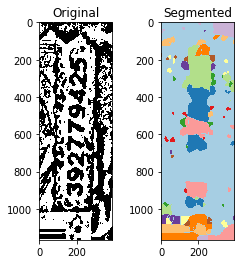

In [14]:
fig = plt.figure(figsize=(4, 4))

a = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(cv2.cvtColor(number_thresholded, cv2.COLOR_GRAY2RGB))
a.set_title('Original')

a = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(labels, cmap='Paired', interpolation='nearest')
a.set_title('Segmented')

plt.show()

# Too slow and strange result. 
### Try source as input

CPU times: user 9.37 s, sys: 12.1 ms, total: 9.38 s
Wall time: 9.38 s


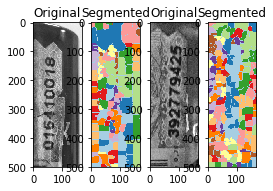

In [25]:
# excise_src = cv2.imread("data/premasked/IMG_0676.JPG")
excise_src = cv2.imread("data/premasked/IMG_0549.JPG")
excise_src2 = cv2.imread("data/premasked/IMG_0560.JPG")
# excise_src = cv2.imread("data/premasked/IMG_0562.JPG")
# excise_src = cv2.imread("data/premasked/IMG_0595.JPG")

number = excise_src[78:78+1166, 1276:1276+392]
number2 = excise_src2[78:78+1166, 1276:1276+392]
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
hsv_image = cv2.cvtColor(number, cv2.COLOR_RGB2HSV)
h, s, v = cv2.split(hsv_image)
v = clahe.apply(v)
resized = imutils.resize(v, height=500)

blurred = cv2.bilateralFilter(resized, 9, 75, 75)
blurred = cv2.medianBlur(blurred, 5)

%time labels = w.apply(blurred)

hsv_image = cv2.cvtColor(number2, cv2.COLOR_RGB2HSV)
h, s, v = cv2.split(hsv_image)
v = clahe.apply(v)
resized2 = imutils.resize(v, height=500)

blurred2 = cv2.bilateralFilter(resized2, 9, 75, 75)
blurred2 = cv2.medianBlur(blurred2, 5)

labels2 = w.apply(blurred2)

fig = plt.figure(figsize=(4, 4))

a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(cv2.cvtColor(resized, cv2.COLOR_GRAY2RGB))
a.set_title('Original')

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(labels, cmap='Paired', interpolation='nearest')
a.set_title('Segmented')

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(cv2.cvtColor(resized2, cv2.COLOR_GRAY2RGB))
a.set_title('Original')

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(labels2, cmap='Paired', interpolation='nearest')
a.set_title('Segmented')

plt.show()

# Great result with clean images. But still too long and worse result with noised images

Try another implementation

CPU times: user 463 ms, sys: 785 µs, total: 463 ms
Wall time: 456 ms


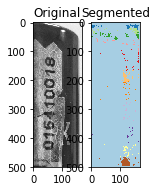

In [19]:
%%time

import scipy.misc
from scipy import ndimage as ndi
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage.filters import sobel
from skimage import morphology
from skimage import segmentation
import skimage

number = excise_src[78:78+1166, 1276:1276+392]
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
hsv_image = cv2.cvtColor(number, cv2.COLOR_RGB2HSV)
h, s, v = cv2.split(hsv_image)
v = clahe.apply(v)
resized = imutils.resize(v, height=500)

distance = ndi.distance_transform_edt(resized)
local_maxi = peak_local_max(distance, labels=resized, footprint=np.ones((3, 3)), indices=False)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=resized)

fig = plt.figure(figsize=(4, 4))

a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(cv2.cvtColor(resized, cv2.COLOR_GRAY2RGB))
a.set_title('Original')

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(labels, cmap='Paired', interpolation='nearest')
a.set_title('Segmented')

# Much faster but still worse result with noised images¶